In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
filename = "email-Eu-core-temporal-Dept3.txt"

In [3]:
import pyspark
import itertools
import pyspark
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import time
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Read data

In [4]:
# create a spark session
spark = SparkSession.builder.appName('link-prediction').getOrCreate()

# read data as list
with open(filename) as csvfile:
    data = [list(map(int, row)) for row in csv.reader(csvfile, delimiter=' ')]

# make a spark dataframe
columns = ["u", "v", "t"]
df = spark.createDataFrame(data=data, schema=columns)

df.toPandas()

,u,v,t
0,11,39,0
1,48,54,2635
2,69,60,4249
3,69,60,13362
4,33,84,16943
...,...,...,...
12211,26,46,45301515
12212,46,26,45301553
12213,16,73,45304269
12214,30,60,45305184


# Select based on timeframe

In [5]:
df1 = df.filter(F.col("t") < 20_000_000)

df1.toPandas()

,u,v,t
0,11,39,0
1,48,54,2635
2,69,60,4249
3,69,60,13362
4,33,84,16943
...,...,...,...
5152,23,88,19987782
5153,87,56,19988698
5154,43,67,19989289
5155,16,15,19989592


# Acquire gamma

In [6]:
gamma = df1\
    .select(F.col("u").alias("v"), F.col("v").alias("u"))\
    .union(df1.select(F.col("u"), F.col("v")))\
    .groupby("u")\
    .agg(F.collect_list("v").alias("edges"))\
    .select(F.col("u").alias("node"), F.array_distinct("edges").alias("gamma"), F.size(F.col("edges")).alias("degree"))\
    .select("node", "gamma", F.size("gamma").alias("gamma_size"), "degree")\
    .filter(F.size("gamma") > 2)

gamma.toPandas()

,node,gamma,gamma_size,degree
0,26,"[57, 51, 24, 18, 65, 35, 37, 33, 25, 46, 4, 39...",13,292
1,29,"[49, 61, 60, 85, 62, 22, 23]",7,38
2,65,"[57, 54, 24, 85, 46, 48, 26, 32, 2, 67, 52, 17...",17,188
3,54,"[48, 22, 65, 39, 24, 84, 60, 49, 63, 88, 52, 6...",24,532
4,19,"[85, 64, 70, 35, 83, 25, 67, 16, 1, 9, 88]",11,204
...,...,...,...,...
69,60,"[69, 16, 29, 23, 49, 88, 14, 25, 43, 21, 66, 7...",33,470
70,16,"[60, 54, 49, 25, 4, 32, 88, 64, 85, 35, 9, 61,...",17,290
71,64,"[39, 85, 19, 1, 83, 16, 58, 4, 49, 55, 25, 35,...",14,146
72,53,"[38, 18, 4, 37, 54, 85, 49, 60, 26]",9,38


# Acquire intersections and unions of pairs

In [7]:
pairs = gamma \
    .withColumnRenamed("node", "_node") \
    .withColumnRenamed("gamma", "_gamma")\
    .join(gamma) \
    .filter(F.col("node") < F.col("_node"))\
    .select(
        F.col("node").alias("u"), 
        F.col("_node").alias("v"), 
        F.array_intersect("gamma", "_gamma").alias("intersection"),
        F.array_union("gamma", "_gamma").alias("union"),
        "gamma",
        (F.size(F.col("gamma")) * F.size(F.col("_gamma"))).alias("preferential_attachment")
    )

    
pairs.toPandas()

,u,v,intersection,union,gamma,preferential_attachment
0,19,26,"[35, 25]","[85, 64, 70, 35, 83, 25, 67, 16, 1, 9, 88, 57,...","[85, 64, 70, 35, 83, 25, 67, 16, 1, 9, 88]",143
1,0,26,[],"[70, 71, 82, 87, 57, 51, 24, 18, 65, 35, 37, 3...","[70, 71, 82, 87]",52
2,22,26,"[35, 4]","[48, 60, 16, 44, 54, 35, 3, 4, 57, 51, 24, 18,...","[48, 60, 16, 44, 54, 35, 3, 4]",104
3,7,26,"[57, 30, 24]","[23, 60, 57, 66, 62, 30, 71, 29, 24, 51, 18, 6...","[23, 60, 57, 66, 62, 30, 71, 29, 24]",117
4,25,26,"[4, 35, 37, 46, 24, 30, 57]","[14, 49, 85, 48, 80, 83, 19, 88, 55, 78, 16, 7...","[14, 49, 85, 48, 80, 83, 19, 88, 55, 78, 16, 7...",468
...,...,...,...,...,...,...
2696,14,24,"[25, 35, 2, 54]","[25, 77, 60, 35, 88, 2, 44, 43, 33, 86, 54, 49...","[25, 77, 60, 35, 88, 2, 44, 43, 33, 86, 54, 49]",240
2697,21,24,"[58, 87, 35]","[69, 60, 23, 58, 87, 66, 62, 30, 24, 35, 49, 7...","[69, 60, 23, 58, 87, 66, 62, 30, 24, 35, 49, 7...",260
2698,15,24,"[48, 25]","[60, 88, 16, 77, 14, 3, 48, 49, 86, 25, 9, 22,...","[60, 88, 16, 77, 14, 3, 48, 49, 86, 25, 9, 22]",240
2699,23,24,"[87, 58, 46, 57, 25, 35, 80, 83, 54, 39]","[69, 87, 58, 62, 49, 46, 60, 30, 57, 25, 35, 8...","[69, 87, 58, 62, 49, 46, 60, 30, 57, 25, 35, 8...",380


# Results

In [8]:
results1 = pairs\
    .select(
        F.concat(F.col("u"), F.lit(","), F.col("v")).alias("u,v"),
        F.size(F.col("intersection")).alias("common_neighbors"),
        (F.size(F.col("intersection"))/(F.size(F.col("union")) + 1e-10)).alias("jaccard_similarity"),
        "preferential_attachment"
    )

results1.toPandas()

,"u,v",common_neighbors,jaccard_similarity,preferential_attachment
0,"19,26",2,0.090909,143
1,"0,26",0,0.000000,52
2,"22,26",2,0.105263,104
3,"7,26",3,0.157895,117
4,"25,26",7,0.166667,468
...,...,...,...,...
2696,"14,24",4,0.142857,240
2697,"21,24",3,0.100000,260
2698,"15,24",2,0.066667,240
2699,"23,24",10,0.344828,380


In [9]:
split = pairs\
    .select(
        F.concat(F.col("u"), F.lit(","), F.col("v")).alias("u,v"),
        F.explode(pairs.intersection).alias("intersection")
)

split.toPandas()

,"u,v",intersection
0,"19,26",35
1,"19,26",25
2,"22,26",35
3,"22,26",4
4,"7,26",57
...,...,...
9014,"16,24",54
9015,"16,24",25
9016,"16,24",4
9017,"16,24",85


In [10]:
results2 = split\
    .join(gamma, split.intersection == gamma.node, "left")\
    .groupby("u,v")\
    .agg(
        F.sum(1/F.log(F.col("gamma_size"))).alias("adamic-adar"),
        F.sum(1/F.col("gamma_size")).alias("resource_allocation"),
        (F.sum(F.col("degree")/F.log(F.col("gamma_size"))).alias("cngf"))
    )

results2.orderBy("u,v").toPandas()

,"u,v",adamic-adar,resource_allocation,cngf
0,"0,1",0.378923,0.071429,28.798162
1,"0,17",0.434294,0.100000,71.224295
2,"0,19",0.480898,0.125000,55.784208
3,"0,21",0.813218,0.171429,100.022457
4,"0,23",0.813218,0.171429,100.022457
...,...,...,...,...
2352,"9,85",0.740548,0.136364,153.012853
2353,"9,86",0.455120,0.111111,14.563828
2354,"9,87",1.366216,0.214753,211.225401
2355,"9,88",1.840484,0.334687,259.382015


# Prediction

In [11]:
keys1 = ["common_neighbors", "jaccard_similarity", "preferential_attachment"]
predictions1 = list(map(lambda key: results1\
    .orderBy(F.col(key).desc())\
    .select("u,v")\
    .rdd\
    .map(lambda row: row[0])\
    .collect(), keys1))

keys2 = ["adamic-adar", "resource_allocation", "cngf"]
predictions2 = list(map(lambda key: results2\
    .orderBy(F.col(key).desc())\
    .select("u,v")\
    .rdd\
    .map(lambda row: row[0])\
    .collect(), keys2))

keys = keys1 + keys2
predictions = predictions1 + predictions2

# ROC curve

In [12]:
df2 = df.filter(F.col("t") >= 20_000_000).filter(F.col("t") < 22_000_000)

labels = df2\
    .filter(F.col("u") < F.col("v"))\
    .select((F.concat(F.col("u"), F.lit(","), F.col("v"))).alias("u,v"))\
    .union(
        df2\
        .filter(F.col("u") > F.col("v"))\
        .select((F.concat(F.col("v"), F.lit(","), F.col("u"))).alias("u,v"))\
    )\
    .distinct();
    
labels = labels\
    .rdd\
    .map(lambda row: row[0])\
    .collect()

len(labels)

185

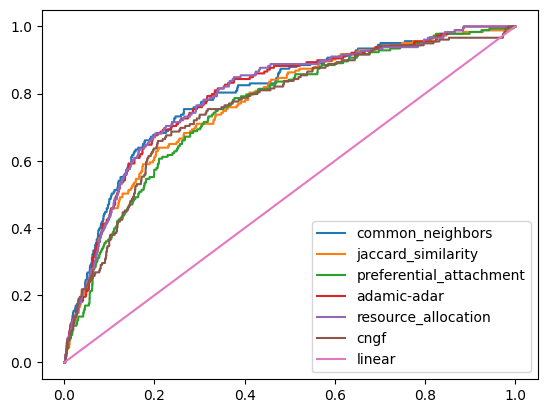

<Figure size 640x480 with 0 Axes>

In [13]:

def roc(pairs, labels):
    labels = set(labels).intersection(set(pairs))
    
    #  threshold = infinite
    tp, fp, fn, tn = 0, 0, len(labels), len(pairs) - len(labels) 
    
    fprs, tprs = [], []
    fprs.append(fp / (fp + tn + 1e-10))
    tprs.append(tp / (tp + fn + 1e-10))
    
    for pair in pairs:
        if pair in labels:
            tp += 1
            fn -= 1
        else:
            fp += 1
            tn -= 1
        fprs.append(fp / (fp + tn + 1e-10))
        tprs.append(tp / (tp + fn + 1e-10))
        
    tp, fp ,fn, tn = len(labels), len(pairs) - len(labels), 0, 0
    fprs.append(fp / (fp + tn + 1e-10))
    tprs.append(tp / (tp + fn + 1e-10))
    
    return fprs, tprs

auc_scores = {}
for key, prediction in zip(keys, predictions):
    fprs, tprs = roc(prediction, labels)
    auc_scores[key] = np.trapz(tprs, fprs)
    plt.plot(fprs, tprs, label=key)
plt.plot(np.arange(len(fprs))/len(fprs), np.arange(len(fprs))/len(fprs), label="linear")
plt.legend()
plt.show()
plt.clf()


In [14]:
pd.DataFrame(auc_scores.items(), columns=['Algorithm', 'AUC Score'])

,Algorithm,AUC Score
0,common_neighbors,0.794670
1,jaccard_similarity,0.769945
2,preferential_attachment,0.756190
3,adamic-adar,0.794389
4,resource_allocation,0.795525
5,cngf,0.761662
